# CIFAR-100 \~\~\~Baseline Version\~\~\~
This is a notebook which classified CIFAR-100 by using google colaboratory.<br>
Test accuracy was 69.19 %.<br>
## Summary
* Accelerator: TPU
* Data Augmentation: Horizontal Flip, Random Crop (Parallel Transformation)
* Model: (Conv-BN-Conv-BN-MaxPool)x2 - Conv - BN - Conv - BN - GAP - Dropout - Dense - Dropout - Dense
* Training: epochs<=100, batch_size=64, optimizer=Adam, Reduce Learning Rate

Mount My Drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

work_dir = "/content/drive/My Drive/Colab Notebooks/cifar100/"

Mounted at /content/drive


Import modules

In [ ]:
!pip install visualkeras
from visualkeras import layered_view

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import cv2

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict

import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.utils import plot_model
#from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.losses import categorical_crossentropy

print('tensorflow varsion:', tf.__version__)
print(tf.test.gpu_device_name())

tensorflow varsion: 2.4.1



Prepare for using TPU

In [ ]:
tf.keras.backend.clear_session()

resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)

# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.experimental.TPUStrategy(resolver)

INFO:tensorflow:Initializing the TPU system: grpc://10.19.13.146:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.19.13.146:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


# Load and check data

Load data

In [ ]:
classes = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
            'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
            'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
            'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
            'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
            'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
            'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
            'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
            'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
            'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
            'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
            'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
            'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
            'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
            'worm']

len(classes)

100

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar100.load_data()

169009152/169001437 [==============================] - 3s 0us/step


Check data

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [ ]:
np.min(X_train), np.max(X_train), np.min(X_test), np.max(X_test)

(0, 255, 0, 255)

In [ ]:
def plot_count(y, classes=None, title='y count'):
    plt.figure(figsize=(10,5))
    counter_y = [(key, value) for key, value in Counter(y).items()]
    counter_y.sort(key=lambda x: x[0])
    if classes is None:
        classes = [key for key, value in counter_y]
    values = [value for key, value in counter_y]
    plt.bar(classes, values)
    plt.xlabel('classes')
    plt.ylabel('count')
    plt.title(title)
    plt.show()


# show 10 images
def show_images(X, y_true=np.zeros(10), y_pred=None, classes=defaultdict(str)):
    plt.figure(figsize=(10,5))
    for i in range(min(10, X.shape[0], y_true.shape[0])):
        plt.subplot(2,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        # plot image
        try:
            plt.imshow(X[i], cmap=plt.cm.binary)
        except:
            plt.imshow(np.reshape(X[i],(X.shape[1],X.shape[2])), cmap=plt.cm.binary)

        # show y_true
        label = ''
        if len(y_true.shape) == 1:
            label += classes[y_true[i]]
        elif len(y_true.shape) == 2:
            label_rate = np.argsort(y_true[i])[::-1]
            if y_true[i][label_rate[0]] > 0.99:
                label = classes[label_rate[0]]
            else:
                label += classes[label_rate[0]] + ': ' + f'{y_true[i][label_rate[0]]:.2f}'
                label += '\n' + classes[label_rate[1]]+': ' + f'{y_true[i][label_rate[1]]:.2f}'
                
        # show y_pred
        if y_pred is None:
            plt.xlabel(label)
            continue

        plt.ylabel('Answer: ' + label)
        label = 'Prediction\n'
        if len(y_pred.shape) == 1:
            label += classes[y_pred[i]]
        elif len(y_pred.shape) == 2:
            label_rate = np.argsort(y_pred[i])[::-1]
            label += classes[label_rate[0]] + ': ' + f'{y_pred[i][label_rate[0]]:.2f}'
            if y_pred[i][label_rate[1]] > 0.01:
                label += '\n' + classes[label_rate[1]]+': ' + f'{y_pred[i][label_rate[1]]:.2f}'
        plt.xlabel(label)

    plt.show()

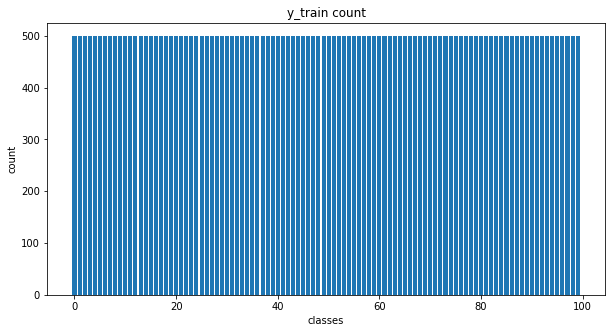

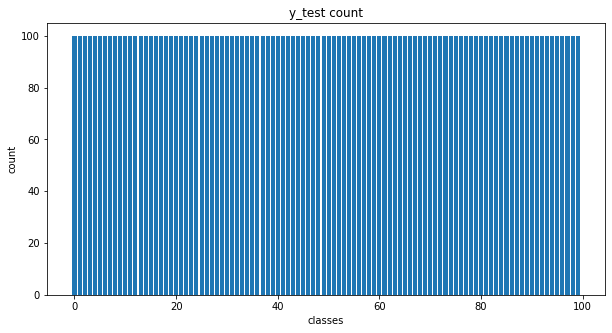

In [ ]:
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

plot_count(y_train, title='y_train count')
plot_count(y_test, title='y_test count')

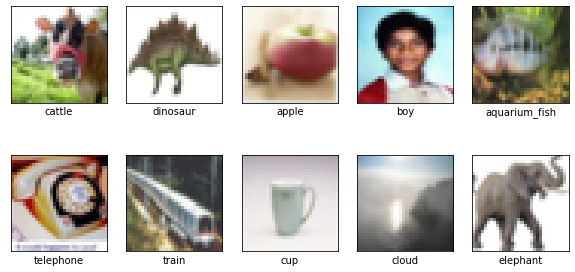

In [ ]:
show_images(X_train, y_train, classes=classes)

# Preprocess data

Normalize images

In [ ]:
X_train = X_train / 255
X_test = X_test / 255
np.min(X_train), np.max(X_train), np.min(X_test), np.max(X_test)

(0.0, 1.0, 0.0, 1.0)

Change shapes

In [ ]:
y_train = keras.utils.to_categorical(y_train, len(classes))
y_test = keras.utils.to_categorical(y_test, len(classes))

train_test_split

In [ ]:
validation_seed = 0
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=validation_seed)

print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)
(40000, 100) (10000, 100) (10000, 100)


# Augment data

In [ ]:
batch_size = 64
steps_per_epoch = X_train.shape[0] // batch_size
epochs = 100

In [ ]:
def data_augmentation(img):
    img = tf.image.random_flip_left_right(img)
    img = tf.pad(img, tf.constant([[4,4],[4,4],[0,0]]), 'SYMMETRIC')
    img = tf.image.random_crop(img, size=X_train[0].shape)
    return img

Before augmentation


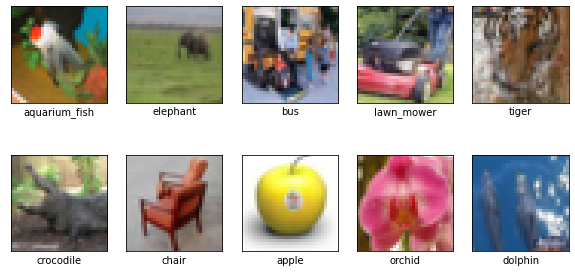

In [ ]:
print('Before augmentation')
show_images(X_train[10:20], y_train[10:20], classes=classes)

After augmentation


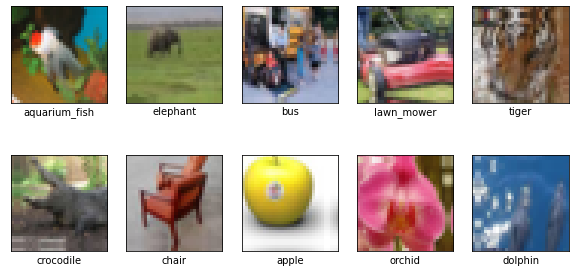

In [ ]:
print('After augmentation')
X_aug = np.array([data_augmentation(img) for img in X_train[10:20]])
show_images(X_aug, y_train[10:20], classes=classes)

In [ ]:
trainset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
trainset = trainset.map(lambda img, label:(data_augmentation(img), label))
trainset = trainset.shuffle(buffer_size=1024).repeat().batch(64)

In [ ]:
print('Data augmentation uses this time per 1 epoch.')

def measure_time(datagen_flow, steps_per_epoch):
    cnt = 0
    for X_aug, y_aug in datagen_flow:
        cnt += 1
        if cnt == steps_per_epoch:
            break

%timeit -r 5 measure_time(trainset, steps_per_epoch)

Data augmentation uses this time per 1 epoch.
1 loop, best of 5: 5.54 s per loop


# Create model

In [ ]:
def create_model(input_shape, num_classes):
    filters = 64
    repeat = 3

    inputs = Input(shape=input_shape)
    x = inputs
    
    for i in range(repeat):
        x = Conv2D(filters, (3,3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters, (3,3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        if i < repeat - 1:
            x = MaxPooling2D(pool_size=(2,2))(x)
            filters *= 2

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.25)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

In [ ]:
model = create_model(input_shape=X_train[0].shape, num_classes=len(classes))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856 

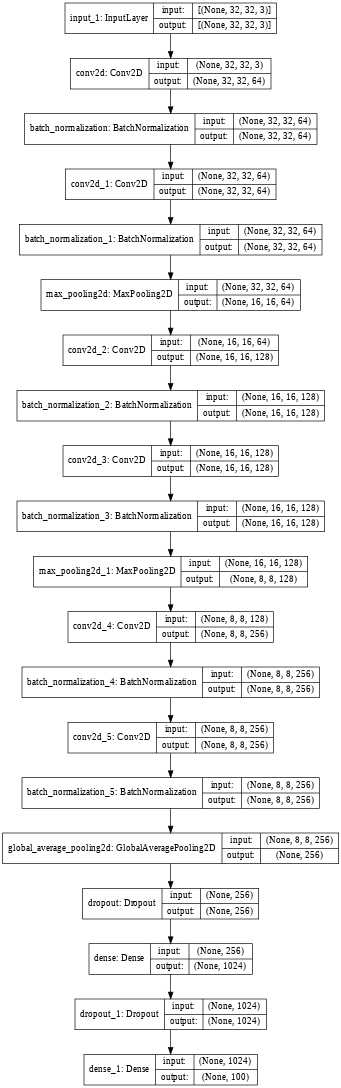

In [ ]:
plot_model(model, show_shapes=True, dpi=48)

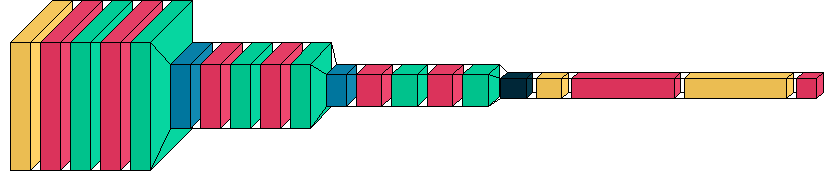

In [ ]:
layered_view(model)

# Train model

In [ ]:
weights_file_name = "baseline_weights(seed={}).hdf5".format(validation_seed)
model_file_name = "baseline_model(seed={}).h5".format(validation_seed)

In [ ]:
%%time

with strategy.scope():
    model = create_model(input_shape=X_train[0].shape, num_classes=len(classes))
    model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])

save_weights = ModelCheckpoint(filepath=os.path.join(work_dir, weights_file_name),
                                verbose=0, save_best_only=True, save_weights_only=True,
                                monitor='val_loss', mode='min')

early_stop = EarlyStopping(monitor='val_loss', mode='min',
                                patience=15, restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min',
                                factor=0.8, patience=5, verbose=1)

model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])

history = model.fit(trainset,
                    validation_data=(X_valid, y_valid),
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    verbose=2,
                    callbacks=[save_weights, early_stop, reduce_lr])

model.save(os.path.join(work_dir, model_file_name))

Epoch 1/100
625/625 - 18s - loss: 3.9323 - accuracy: 0.0953 - val_loss: 3.5150 - val_accuracy: 0.1591
Epoch 2/100
625/625 - 8s - loss: 3.2804 - accuracy: 0.1945 - val_loss: 3.3080 - val_accuracy: 0.2145
Epoch 3/100
625/625 - 8s - loss: 2.8925 - accuracy: 0.2637 - val_loss: 2.5524 - val_accuracy: 0.3359
Epoch 4/100
625/625 - 8s - loss: 2.6302 - accuracy: 0.3167 - val_loss: 2.4808 - val_accuracy: 0.3526
Epoch 5/100
625/625 - 8s - loss: 2.4289 - accuracy: 0.3633 - val_loss: 2.1868 - val_accuracy: 0.4203
Epoch 6/100
625/625 - 8s - loss: 2.2674 - accuracy: 0.3997 - val_loss: 1.9700 - val_accuracy: 0.4644
Epoch 7/100
625/625 - 8s - loss: 2.1550 - accuracy: 0.4246 - val_loss: 2.0463 - val_accuracy: 0.4628
Epoch 8/100
625/625 - 8s - loss: 2.0587 - accuracy: 0.4459 - val_loss: 1.8612 - val_accuracy: 0.5008
Epoch 9/100
625/625 - 8s - loss: 1.9588 - accuracy: 0.4681 - val_loss: 1.7701 - val_accuracy: 0.5206
Epoch 10/100
625/625 - 8s - loss: 1.8917 - accuracy: 0.4848 - val_loss: 1.6165 - val_accur

In [ ]:
def plot_history(history):
    # plot accuracy
    plt.figure(figsize=(10,5))
    plt.plot(history.history['accuracy'], marker='.', label='acc')
    plt.plot(history.history['val_accuracy'], marker='.', label='val_acc')
    plt.title('model accuracy')
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='best')
    plt.show()

    # plot loss
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'], marker='.', label='loss')
    plt.plot(history.history['val_loss'], marker='.', label='val_loss')
    plt.title('model loss')
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    plt.show()

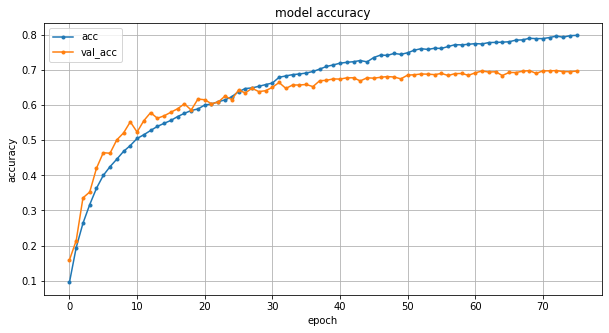

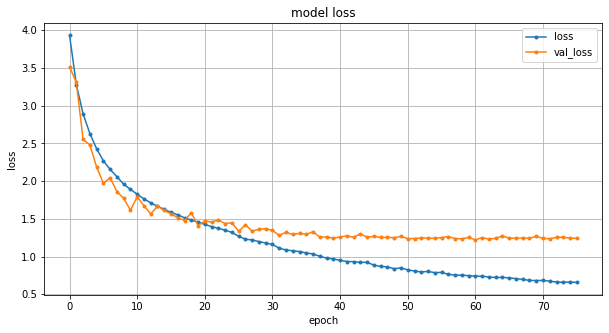

In [ ]:
plot_history(history)

# Analyze validation results

In [ ]:
with strategy.scope():
    model = load_model(os.path.join(work_dir, model_file_name))
    model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])

In [ ]:
def calculate_loss_and_acc(y_test, y_pred):
    loss = np.average(categorical_crossentropy(y_test, y_pred))
    if len(y_test.shape) == 2:
        y_test = np.argmax(y_test, axis=1)
    if len(y_pred.shape) == 2:
        y_pred = np.argmax(y_pred, axis=1)
    acc = np.average(np.equal(y_test, y_pred))
    print('loss:', loss, 'acc:', acc)


def confusion_classes(y_test, y_pred, classes):
    if len(y_test.shape) == 2:
        y_test = np.argmax(y_test, axis=1)
    if len(y_pred.shape) == 2:
        y_pred = np.argmax(y_pred, axis=1)

    cmx = confusion_matrix(y_test, y_pred)
    cmx = np.ravel(cmx)
    cmx_idx = np.argsort(cmx)[::-1]
    table = []
    for i in range(len(classes)+10):
        pred = cmx_idx[i] // len(classes)
        ans = cmx_idx[i] % len(classes)
        if pred != ans:
            table.append([classes[pred], classes[ans], cmx[cmx_idx[i]]])
    return pd.DataFrame(table, columns=['answer','prediction','counts'])

In [ ]:
%%time
print('validation results')
y_pred = model.predict(X_valid)
calculate_loss_and_acc(y_valid, y_pred)

validation results
loss: 1.215943 acc: 0.6913
CPU times: user 1.43 s, sys: 689 ms, total: 2.11 s
Wall time: 5.78 s


In [ ]:
confusion_classes(y_valid, y_pred, classes)

,answer,prediction,counts
0,maple_tree,oak_tree,24
1,man,woman,22
2,plain,sea,22
3,pine_tree,oak_tree,19
4,apple,pear,16
5,couch,bed,16
6,girl,baby,16
7,girl,woman,16
8,dolphin,shark,15
9,snake,worm,15


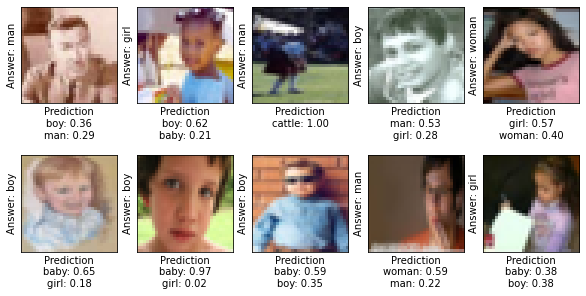

In [ ]:
# show mistaken human images
indexes = [classes.index('boy'), classes.index('girl'),
           classes.index('man'), classes.index('woman')]

miss_X = []
miss_y_valid = []
miss_y_pred = []
for i in range(y_valid.shape[0]):
    if np.argmax(y_valid[i]) in indexes and np.argmax(y_valid[i]) != np.argmax(y_pred[i]):
        miss_X.append(X_valid[i])
        miss_y_valid.append(y_valid[i])
        miss_y_pred.append(y_pred[i])
        if len(miss_X) == 10:
            break

miss_X = np.array(miss_X)
miss_y_valid = np.array(miss_y_valid)
miss_y_pred = np.array(miss_y_pred)
show_images(miss_X, miss_y_valid, miss_y_pred, classes)

# Calculate test loss and accuracy

In [ ]:
print('test results')
y_pred = model.predict(X_test)
calculate_loss_and_acc(y_test, y_pred)

test results
loss: 1.2279896 acc: 0.6919
